**Clustering:**
Dans cette partie, nous récupérons le dataset crée par "prepare_data" afin d'y appliquer deux méthodes de machine learning pour deux buts différents:

**1- l'analyse de composantes principales (PCA):** Cette méthode est utilisée pour réduire la dimentionalité du dataset. D'une part, cela nous permet d'essayer de faire un clustering sur deux dimentions, d'autre part, elle nous permet d'identifier quelles variables séparent mieux le dataset.

**2- le clustering par la méthode des kmeans:** C'est la méthode de clustering qu'on a choisi d'utiliser, pricipalement car on l'a vu en cours, elle est appliquée sur les données de dimention réduite (par la PCA)

Préparation de l'environnement: rien d'exceptionnel ici, on importe les bibliothèques dont on aura besoin

In [1]:
!pip install geopandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import seaborn as sns
from scipy import stats

Lecture du dataset:

In [3]:
camping=pd.read_csv("Datasets/camping.csv")

Vérification des colonnes (on a remarqué ici qu'une nouvelle colonne est ajoutée par le code précédent qui n'a aucune utilité appelée "Unnamed: 0", sans vouloir trop modifier le code précédent, on se contente de l'enlever)

In [4]:
camping.columns

Index(['Unnamed: 0', 'Adresse', 'dep', 'Emplacements', 'Nom', 'Classement',
       'commune', 'code_postal', 'geometry', 'Surface', 'permanence_24h',
       'langues_accueil', 'internet_partout', 'rapport_sans_mobile',
       'distance_police', 'distance_hopitaux', 'defib_moins_2km'],
      dtype='object')

La variable "rapport_sans_mobile" est obsolète car tous les sites de camping ont une couverture réseau totale, on l'enlève aussi

In [5]:
camping_copy=camping.drop(columns=["Unnamed: 0","rapport_sans_mobile"])
camping_copy

,Adresse,dep,Emplacements,Nom,Classement,commune,code_postal,geometry,Surface,permanence_24h,langues_accueil,internet_partout,distance_police,distance_hopitaux,defib_moins_2km
0,Route du Château d'eau,78,180,CAMPING HUTTOPIA RAMBOUILLET,3,RAMBOUILLET,78120,POINT (1.835694 48.630059),18000.0,1,3,0,2817,6807,0
1,11 CHEMIN DU CAMPING,77,440,CAMPING LES PRÉS DE LA FONTAINE,3,HERMÉ,77114,POINT (3.338549 48.472784),44000.0,1,3,0,4953,10485,1
2,26 Route de Vauvert,91,230,CARAVANING LE VAUVERT,4,ORMOY-LA-RIVIÈRE,91150,POINT (2.143939 48.411278),28750.0,1,3,1,5177,691,1
3,chemin des ponceaux,77,140,CAMPING LES ACACIAS,2,BETON-BAZOCHES,77320,POINT (3.239464 48.707003),14000.0,0,1,0,16466,23260,0
4,24 Place de la gare de Faremoutiers,77,316,LE CHÊNE GRIS,4,POMMEUSE,77515,POINT (2.99998 48.800512),39500.0,1,3,1,8711,12013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Les étangs des Carreaux,77,76,CARAVANING LES ÉTANGS DES CARREAUX,1,ROZAY-EN-BRIE,77540,POINT (2.955666 48.689498),7600.0,0,1,0,214,31565,1
61,Chemin des Processions,77,100,LE MARCASSIN,1,MONTEREAU-FAULT-YONNE,77130,POINT (2.96358 48.382568),10000.0,0,1,0,1451,2493,0
62,1 VOIE DES PRES,91,124,CAMPING LE BEAU VILLAGE DE PARIS,3,VILLIERS-SUR-ORGE,91700,POINT (2.303507 48.655043),12400.0,1,3,0,3765,6619,0
63,Rue des mariniers,77,175,CAMPING MUNICIPAL LES BORDS DU LOING,1,SOUPPES-SUR-LOING,77460,POINT (2.730621 48.180505),17500.0,0,1,0,3500,10325,0


On réorganise les colonnes du dataset afin de faciliter les manipulations qui vont suivre

In [6]:
camping_copy.columns

Index(['Adresse', 'dep', 'Emplacements', 'Nom', 'Classement', 'commune',
       'code_postal', 'geometry', 'Surface', 'permanence_24h',
       'langues_accueil', 'internet_partout', 'distance_police',
       'distance_hopitaux', 'defib_moins_2km'],
      dtype='object')

In [7]:
camping_copy=camping_copy[['Adresse', 'dep', 'Nom', 'commune',
       'code_postal', 'geometry','Emplacements', 'Surface', 'permanence_24h',
       'distance_police','distance_hopitaux','defib_moins_2km','langues_accueil','internet_partout', 'Classement']]

In [8]:
#camping_copy=camping_copy.drop(columns=["label"],axis=1)

On enlève les données abérrantes, ils influent négativement sur le résultat du clustening car la méthode des knn est sensible à ce type de données

On a choisit d'utiliser le "zscore" pour les identifier car c'est la métrique qui nous semble la plus intuitive: on enlève les lignes dont les valeurs dépassent la moyenne par 3 écart-types

In [9]:
camping_copy_clean=camping_copy[(np.abs(stats.zscore(camping_copy.iloc[:,6:14].values)) < 3).all(axis=1)]

In [10]:
camping_copy_clean

,Adresse,dep,Nom,commune,code_postal,geometry,Emplacements,Surface,permanence_24h,distance_police,distance_hopitaux,defib_moins_2km,langues_accueil,internet_partout,Classement
0,Route du Château d'eau,78,CAMPING HUTTOPIA RAMBOUILLET,RAMBOUILLET,78120,POINT (1.835694 48.630059),180,18000.0,1,2817,6807,0,3,0,3
1,11 CHEMIN DU CAMPING,77,CAMPING LES PRÉS DE LA FONTAINE,HERMÉ,77114,POINT (3.338549 48.472784),440,44000.0,1,4953,10485,1,3,0,3
2,26 Route de Vauvert,91,CARAVANING LE VAUVERT,ORMOY-LA-RIVIÈRE,91150,POINT (2.143939 48.411278),230,28750.0,1,5177,691,1,3,1,4
3,chemin des ponceaux,77,CAMPING LES ACACIAS,BETON-BAZOCHES,77320,POINT (3.239464 48.707003),140,14000.0,0,16466,23260,0,1,0,2
4,24 Place de la gare de Faremoutiers,77,LE CHÊNE GRIS,POMMEUSE,77515,POINT (2.99998 48.800512),316,39500.0,1,8711,12013,1,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Les étangs des Carreaux,77,CARAVANING LES ÉTANGS DES CARREAUX,ROZAY-EN-BRIE,77540,POINT (2.955666 48.689498),76,7600.0,0,214,31565,1,1,0,1
61,Chemin des Processions,77,LE MARCASSIN,MONTEREAU-FAULT-YONNE,77130,POINT (2.96358 48.382568),100,10000.0,0,1451,2493,0,1,0,1
62,1 VOIE DES PRES,91,CAMPING LE BEAU VILLAGE DE PARIS,VILLIERS-SUR-ORGE,91700,POINT (2.303507 48.655043),124,12400.0,1,3765,6619,0,3,0,3
63,Rue des mariniers,77,CAMPING MUNICIPAL LES BORDS DU LOING,SOUPPES-SUR-LOING,77460,POINT (2.730621 48.180505),175,17500.0,0,3500,10325,0,1,0,1


Ici la partie ACP, le code a été repris d'internet et il est assez décortiqué

In [11]:
X=camping_copy.iloc[:,6:14].values  #récupération des données numériques du dataset
X=X[(np.abs(stats.zscore(X)) < 3).all(axis=1)] #puisque on travaille sur le dataset contenant les données abérrantes, on les enlève aussi de la même manière
y=camping_copy.iloc[:,-1].values #on récupère la colonne du "classement" des sites de camping, afin de l'utiliser comme variable illustrative
from sklearn.preprocessing import StandardScaler, QuantileTransformer,MaxAbsScaler #on a essayé plusieurs preprocess pour les données, le QantileTransformer nous semble le plus adéquat
X_std = QuantileTransformer().fit_transform(X) #normalisation des données
#calculs d'algèbre linéaire: matrice de covariance puis ses valeurs propres et vecteurs propres afin d'avoir la base orthogonale de l'analyse en composantes principales
cov_mat= np.cov(X_std, rowvar=False)
cov_mat = np.cov(X_std.T) 
eig_vals, eig_vecs = np.linalg.eig(cov_mat) 
print('Vecteurs Propres \n%s' %eig_vecs) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp) 
print("\n. Percentage de l'information expliquée par les deux premières composantes\n",sum(var_exp[0:2]))
matrix_w = np.hstack((eig_pairs[0][1].reshape(8,1), eig_pairs[1][1].reshape(8,1))) 
Y = X_std.dot(matrix_w) 
principalDf = pd.DataFrame(data = Y , columns = ['principal component 1', 'principal component 2']) #On récupère les deux premières composantes le l'analyse
finalDf = pd.concat([principalDf,pd.DataFrame(y,columns = ['Classement'])], axis = 1) #on ajoute la variable illustrative

Vecteurs Propres 
[[ 2.97621143e-01  1.29715397e-01 -3.70898638e-01 -4.29862909e-02
   5.26759880e-01  1.25457545e-02 -6.90026965e-01 -3.75681996e-02]
 [ 3.09719971e-01  1.25974828e-01 -3.73127519e-01 -8.26715222e-02
   4.70810831e-01  3.00936266e-03  7.19810482e-01  4.84368893e-02]
 [ 6.80787971e-01 -9.19250676e-02  3.17147373e-01  2.26480215e-01
  -1.31387510e-01  1.58833888e-02 -4.07669000e-02  5.97515587e-01]
 [ 2.96639277e-03 -2.78265753e-01  2.80797711e-01 -4.50622361e-01
   2.10113327e-01  7.72335443e-01  4.80386487e-04  1.27571001e-03]
 [-1.62592566e-02 -1.06379753e-01  5.04441802e-01 -4.87599344e-01
   3.61355742e-01 -6.04485096e-01 -3.70397108e-03  1.45054892e-02]
 [ 2.97563660e-02  9.29542445e-01  2.88968583e-01 -1.48910981e-01
  -6.19540961e-02  1.59714699e-01 -2.54383943e-03 -5.87477440e-03]
 [ 5.19668783e-01 -7.66978781e-02  2.30655357e-01  1.42697537e-01
  -9.93120679e-02 -1.92123142e-03  4.45154101e-02 -7.99155249e-01]
 [ 2.84268685e-01 -1.31847347e-02 -3.90658389e-01 -

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (63). n_quantiles is set to n_samples.
  warnings.warn(


In [12]:
d = {'Emplacements': [2.97580833e-01, 3.09418921e-01], 'Surface': [1.29740201e-01, 1.25379445e-01],'permanence_24h': [-3.70869624e-01, -3.73244985e-01], 'distance_police': [-4.24798132e-02, -8.15507286e-02],'distance_hopitaux': [5.27147381e-01, 4.70898862e-01], 'defib_moins_2km': [1.26041619e-02, 3.02460852e-03], 'langues_accueil':[-6.89801476e-01,7.20066320e-01], 'internet_partout':[-3.73498852e-02,4.82410046e-02]}
explained_variables = pd.DataFrame(data=d)

In [13]:
explained_variables

,Emplacements,Surface,permanence_24h,distance_police,distance_hopitaux,defib_moins_2km,langues_accueil,internet_partout
0,0.297581,0.129740,-0.370870,-0.042480,0.527147,0.012604,-0.689801,-0.037350
1,0.309419,0.125379,-0.373245,-0.081551,0.470899,0.003025,0.720066,0.048241


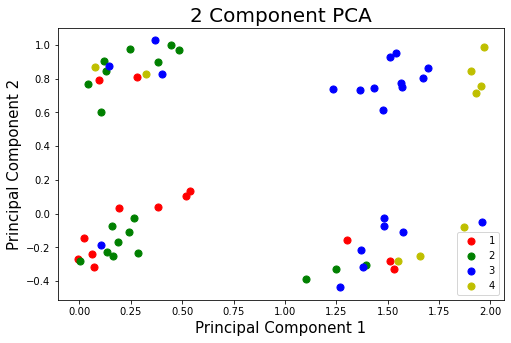

In [14]:
fig = plt.figure(figsize = (8,5)) 
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15) 
ax.set_ylabel('Principal Component 2', fontsize = 15) 
ax.set_title('2 Component PCA', fontsize = 20) 
targets = [1, 2,3,4]#,3,4]
colors = ['r', 'g', 'b', 'y'] 
for target, color in zip(targets,colors): 
    indicesToKeep = finalDf['Classement'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'] , finalDf.loc[indicesToKeep, 'principal component 2'] , c = color , s = 50) 
    ax.legend(targets) 
    ax.grid()

**Explication des sorties:**

L'analyse en composantes principales permet d'identifier les variables qui contiennent la majorité de l'information sur le jeu de données. Dans notre cas, on observe que les deux premiers vecteurs propres générés par cette méthode expriment approximativement 70% de l'information présente dans le jeu de données, c'est à dire qu'on pourra négliger tous les autres vecteurs sans perdre trop d'informations.

Pour l'identification de l'impact des variables sur les composantes principales, on remarque que la distance aux hopitaux et la surface et nombre d'emplacements augmentent en diagonale, c'est à dire que le cluster du nord-est représente les sites de camping les plus grands et les plus isolés des hopitaux, parcontre, le cluster du sud-ouest représente ceux qui sont plus petits mais plus proches des hopitaux

Pour la composante principale 2, on remarque qu'elle est positivement corrélée avec le nombre de langues parlés à l'acceuil et un peu moin avec la présence d'internet sur l'ensemble du site, on pourra dire qu'elle caractérise la "quality of life" d'un site de camping, les clusters du nord sont plus "luxe" que ceux au sud

Pour simplifier, on pourra dire que l'axe de la composante principale 1 caractérise la taille des sites et leur isolation de la civilisation, tout en remarquant que cette isolation s'exprime par leur distance aux hopitaux et non aux postes de police car il existe des postes de gendarmeries assez isolés aussi

Et concernant l'axe de la composante principale 2, il caractérise la "qualité" d'un site de camping notemment vis-à-vis son acceuil

On pourra conclure donc, concernant la sécurité des sites de camping, que la variable principale (au sens de la sécurité des sites) qui les différencie est celle de la distance par rapport aux hopitaux, cette distance semble être plus grande pour les sites les plus larges et les plus luxurieux. On pourra donc dire qu'il est possible d'être plus en sécurité dans un site de camping concidéré comme "bas de gamme"

Cette partie du code exécute le clustering par kmeans:


In [15]:
xvars = ['principal component 1', 'principal component 2'] # récupération des données de l'ACP
df2 = finalDf[xvars].dropna()

In [16]:
df2

,principal component 1,principal component 2
0,1.479893,-0.071411
1,1.698260,0.865848
2,1.905159,0.844574
3,0.284418,-0.235157
4,1.952528,0.758126
...,...,...
58,0.141677,0.877434
59,0.190040,0.031476
60,1.304236,-0.155677
61,0.382337,0.041593


In [17]:
df2_copy=camping_copy_clean

Exécution de la méthode du coude pour identifier le nombre optimal de clusters:

In [18]:
distortions = []
K = range(1,10)
for k in K:
  model = KMeans(n_clusters=k)
  model.fit(df2[xvars])
  distortions.append(model.inertia_)

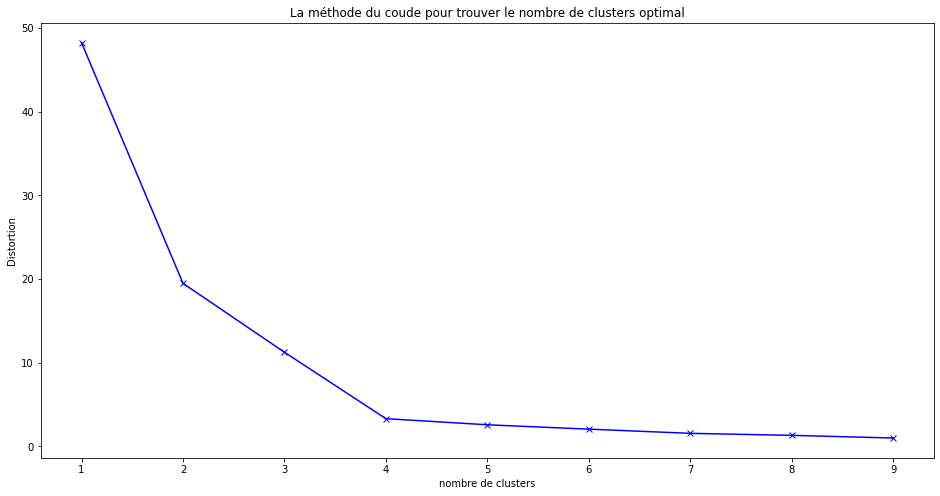

In [19]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('nombre de clusters')
plt.ylabel('Distortion')
plt.title('La méthode du coude pour trouver le nombre de clusters optimal')
plt.show()

On identifie bien 4 clusters, cela est consistant avec l'observation qu'on a fait avec le résultat de l'ACP

In [20]:
model = KMeans(n_clusters=4) #exécution de l'algorithme de kmeans
model.fit(df2[xvars])

KMeans(n_clusters=4)

In [21]:
df2_copy['label'] = model.labels_ #sauvegarde des indices de clusters trouvés

/tmp/ipykernel_2069/2016269937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_copy['label'] = model.labels_ #sauvegarde des indices de clusters trouvés


In [22]:
from geopandas import GeoDataFrame

df2_copy = GeoDataFrame(df2_copy)

In [23]:
finalDf=finalDf.dropna()

Affichage final des clusters:

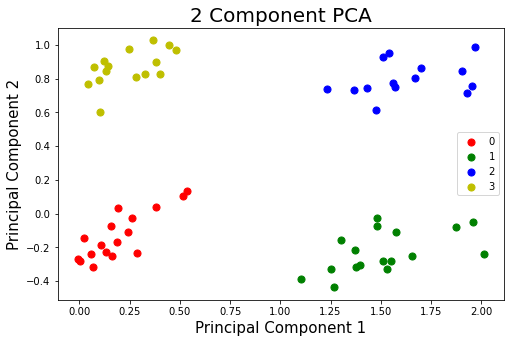

In [24]:
finalDF_copy=finalDf.dropna()
finalDF_copy['label'] = model.labels_
fig = plt.figure(figsize = (8,5)) 
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15) 
ax.set_ylabel('Principal Component 2', fontsize = 15) 
ax.set_title('2 Component PCA', fontsize = 20) 
targets = [0,1,2,3]#,4]#,3,4]
colors = ['r', 'g', 'b', 'y'] 
for target, color in zip(targets,colors): 
    indicesToKeep = finalDF_copy['label'] == target
    ax.scatter(finalDF_copy.loc[indicesToKeep, 'principal component 1'] , finalDF_copy.loc[indicesToKeep, 'principal component 2'] , c = color , s = 50) 
    ax.legend(targets) 
    ax.grid()

In [25]:
camping_copy_clean.to_csv("camping_labelled.csv") #sauvegarde en .csv pour la visualisation

In [26]:
!jupyter nbconvert --to html clustering.ipynb

[NbConvertApp] Converting notebook clustering.ipynb to html
[NbConvertApp] Writing 713155 bytes to clustering.html
